### Re-run some feature-specific, just grouping by RPE Group

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
from utils.session_data import SessionData
import utils.io_utils as io_utils
from utils.constants import *
import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import LinearRegression

In [2]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

In [3]:
MIN_NUM_TRIALS = 50
CONDITIONS = ["RPEGroup"]
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
# REGION = "all"
REGION = "Parietal Cortex"

valid_sess = pd.read_pickle(SESSIONS_PATH)
units = spike_utils.get_unit_positions(valid_sess)
# region_units = units[units.manual_structure == "Prefrontal Cortex"]
region_units = units[units.manual_structure == "Parietal Cortex"]

# region_units = units[units.manual_structure == "Claustrum"]

# region_units = units[units.structure_level2 == REGION]
# region_units = units[units.structure_level3 == REGION]

# region_units = units

In [9]:
# NOTE: maybe don't balance for now, 
def validate_and_label_sessions(row, feature, region_units):
    # check region specificity:
    # if not row.session_name in region_units.session.values:
    #     return None
    labeled_beh = behavioral_utils.get_beh_model_labels_for_session_feat(row.session_name, feature)
    labeled_beh = labeled_beh[labeled_beh.Response == "Correct"]
    enough_trials = behavioral_utils.validate_enough_trials_by_condition(labeled_beh, CONDITIONS, MIN_NUM_TRIALS, num_unique_conditions=2)
    if not enough_trials:
        return None
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=row.session_name, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(row.session_name) * 100 + frs["UnitID"]
    frs = frs[frs.PseudoUnitID.isin(region_units.PseudoUnitID)]
    merged = pd.merge(labeled_beh, frs, on="TrialNumber")
    if len(merged) == 0:
        return None
    return merged


### Plot average of projected magnitude between RPE Groups

In [ ]:
for feature in FEATURES: 
    res = valid_sess.apply(lambda x: validate_and_label_sessions(x, feature, region_units), axis=1)
    res = res.dropna()
    print(f"{feature} has {len(res)} sessions")
    all_trials = pd.concat(res.values)
    all_trials["Condition"] = all_trials.RPEGroup
    all_trials.to_pickle(f"/data/patrick_res/feature_specific/{feature}_cor_only_rpe_group.pickle")

In [16]:
reses = []
for feature in FEATURES: 
    all_trials = pd.read_pickle(f"/data/patrick_res/feature_specific/{feature}_cor_only_rpe_group.pickle")
    conditions = all_trials.Condition.unique()
    conditions.sort()
    base_frs = all_trials.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("BaseFiringRate").reset_index()
    conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()
    for condition in conditions:
        frs = conditioned_frs[conditioned_frs.Condition == condition]
        merged = pd.merge(frs, base_frs, on=["PseudoUnitID", "TimeBins"])
        def calc_proj(group):
            dot = np.dot(group.ConditionedFiringRate, group.BaseFiringRate)
            # base_mag = np.sqrt(np.sum(group.BaseFiringRate ** 2))
            base_mag = np.sum(group.BaseFiringRate ** 2)
            proj = dot / base_mag
            return proj
        res = merged.groupby("TimeBins").apply(calc_proj).to_frame("Proj").reset_index()
        res["Feature"] = feature
        res["Condition"] = condition
        reses.append(res)

reses = pd.concat(reses)

In [17]:
avgs = reses.groupby(["TimeBins", "Condition"], as_index=False).agg({"Proj": ["mean", "std"]})
avgs.columns = ["TimeBins", "Condition", "ProjMean", "ProjStd"]

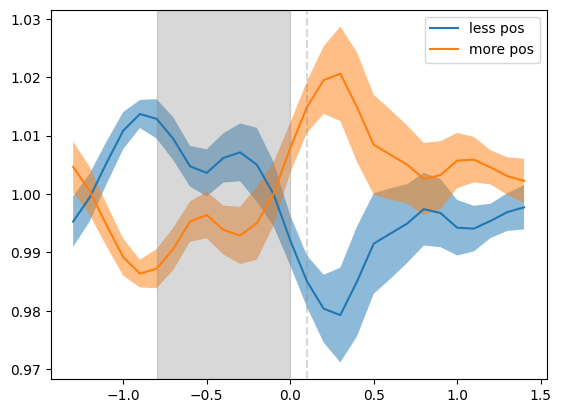

In [18]:
fig, ax = plt.subplots()
for condition in conditions:
    cond_avgs = avgs[avgs.Condition == condition]
    times = cond_avgs.TimeBins - 1.3
    ax.plot(times, cond_avgs.ProjMean, label=condition)
    std_line = ax.fill_between(
        times, 
        cond_avgs.ProjMean - cond_avgs.ProjStd, 
        cond_avgs.ProjMean + cond_avgs.ProjStd, 
        alpha=0.5
    )
ax.legend()
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')

### Can this be explained by magnitude in general of neural activity in the different groups?

In [33]:
def label_rpe_group_sessions(row):
    labeled_beh = behavioral_utils.get_beh_model_labels_for_session_feat(row.session_name, feature)
    labeled_beh = labeled_beh[labeled_beh.Response == "Correct"]
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=row.session_name, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(row.session_name) * 100 + frs["UnitID"]
    merged = pd.merge(labeled_beh, frs, on="TrialNumber")
    return merged

In [38]:
res = valid_sess.apply(label_rpe_group_sessions, axis=1)
all_trials = pd.concat(res.values)

In [47]:
base_frs = all_trials.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("BaseFiringRate").reset_index()
conditioned_frs = all_trials.groupby(["RPEGroup", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()
conditions = all_trials.RPEGroup.unique()
conditions.sort()
reses = []
for condition in conditions:
    frs = conditioned_frs[conditioned_frs.RPEGroup == condition]
    merged = pd.merge(frs, base_frs, on=["PseudoUnitID", "TimeBins"])
    def calc_mag_ratio(group):
        cond_mag = np.sum(group.ConditionedFiringRate**2)
        # base_mag = np.sqrt(np.sum(group.BaseFiringRate ** 2))
        base_mag = np.sum(group.BaseFiringRate ** 2)
        ratio = cond_mag / base_mag
        return ratio
    res = merged.groupby("TimeBins").apply(calc_proj).to_frame("MagRatio").reset_index()
    res["RPEGroup"] = condition
    reses.append(res)
reses = pd.concat(reses)

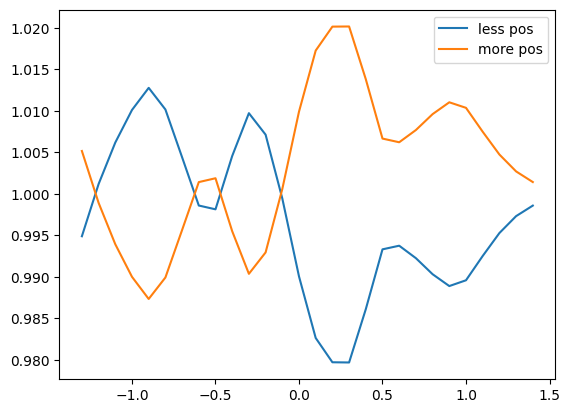

In [48]:
fig, ax = plt.subplots()
for condition in conditions:
    ratios = reses[reses.RPEGroup == condition]
    times = cond_avgs.TimeBins - 1.3
    ax.plot(times, ratios.MagRatio, label=condition)
ax.legend()

### Wonder what RSA matrices look like across time

In [8]:
FEATURE = "SWIRL"
all_trials = pd.read_pickle(f"/data/patrick_res/feature_specific/{FEATURE}_cor_only_rpe_group.pickle")
conditions = all_trials.Condition.unique()
conditions.sort()
base_frs = all_trials.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("FiringRate").reset_index()
conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("FiringRate").reset_index()

In [9]:
def get_cor_mat_by_time(frs, time_bins):
    cor_mat = np.empty((len(time_bins), len(time_bins)))
    for i, time_bin_i in enumerate(time_bins):
        for j, time_bin_j in enumerate(time_bins):
            frs_i = frs[np.isclose(frs.TimeBins, time_bin_i)].sort_values(by="PseudoUnitID")
            frs_j = frs[np.isclose(frs.TimeBins, time_bin_j)].sort_values(by="PseudoUnitID")
            coefs = np.corrcoef([frs_i.FiringRate.values, frs_j.FiringRate.values])
            cor_mat[i, j] = coefs[0, 1]
    return cor_mat

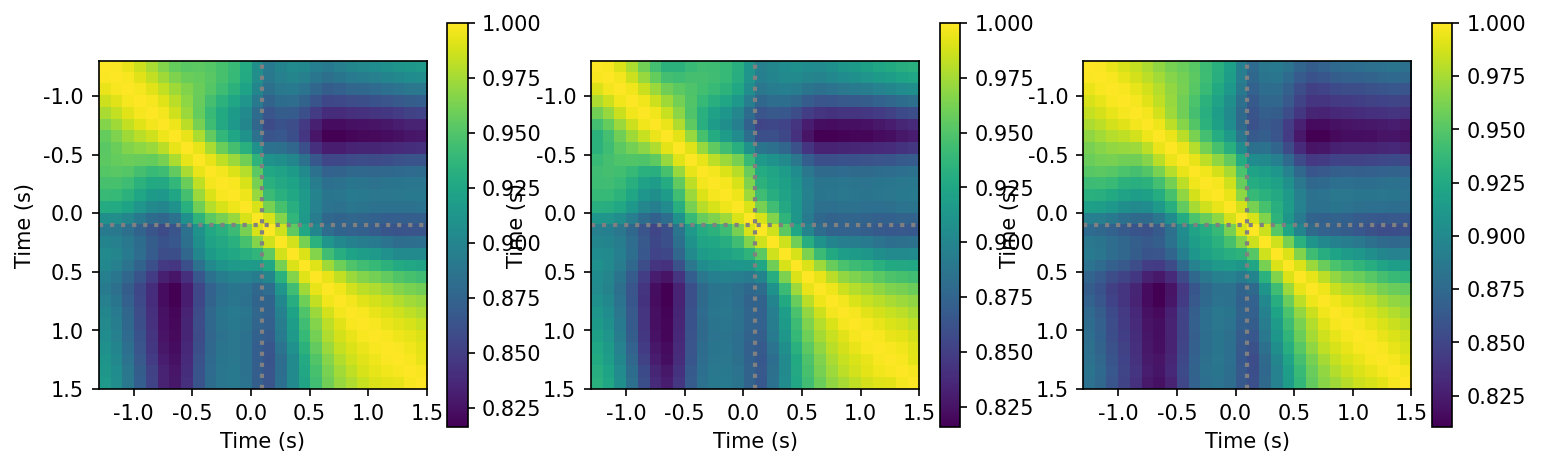

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), dpi=150)
time_bins = np.arange(0, 2.8, 0.1)
labels = ["base", "less pos", "more pos"]
less_pos_frs = conditioned_frs[conditioned_frs.Condition == "less pos"]
more_pos_frs = conditioned_frs[conditioned_frs.Condition == "more pos"]
frs = [base_frs, less_pos_frs, more_pos_frs]
for i, label in enumerate(labels):
    fr = frs[i]
    ax = axs[i]
    mat = get_cor_mat_by_time(fr, time_bins)
    colors = ax.matshow(mat)
    fig.colorbar(colors, ax=ax)

    ratio = 1000 / 100
    tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_pos = (tick_labels + 1.3) * ratio - 0.5

    # colors.set_clim(vmin=0.25)

    # tick_labels = np.arange(len(cross_accs))
    # tick_pos = np.arange(len(cross_accs))
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Time (s)")
    # ax.set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")
    ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=2)
    ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=2)